In [1]:
import os
from pathlib import Path

print("cwd:", Path.cwd())              # where Python is looking right now
print("exists Data?:", Path('Data').exists())
print("listing cwd:", os.listdir('.'))

# /Users/gopaljee45/Desktop/codinG/SA_2025/Default_Loan_Prediction/Jupyter_Notebooks

cwd: /Users/gopaljee45/Desktop/codinG/SA_2025/Default_Loan_Prediction/Jupyter_Notebooks
exists Data?: False
listing cwd: ['5_Model_Tuning.ipynb', '1_Joint_Loan_Analysis.ipynb', '.DS_Store', 'conda_env_explicit.txt', '2_Splitting_Data.ipynb', 'Models', '3_Scaling_Data.ipynb', '6_Model_Validation.ipynb', 'conda_env_backup.yml', '7_ConfidenceInterval.ipynb', '4_Model_Selection.ipynb', 'plots']


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import math 
from sklearn.preprocessing import LabelEncoder
import shap
import os
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [3]:
# to avoid warnings in [24]
pd.set_option('future.no_silent_downcasting', True)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [4]:
#Reading the Dataset
new_data=pd.read_csv('/Users/gopaljee45/Desktop/codinG/SA_2025/Default_Loan_Prediction/Data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=False)

In [5]:
new_data.shape

(2260701, 151)

In [6]:
#Response/Target Variable 
new_data.loan_status.value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

#### str.contains("Fully")
- For every entry (string) in that column, it checks whether the substring "Fully" appears.
- Returns a boolean Series of True/False.
#### np.where(condition, 0, 1)
- This replaces each True with 0 and each False with 1.

In [7]:
#Considering only Fully Paid, Default, Charged Off Loans.
resp=['Current']
Loan_Main = new_data[~new_data['loan_status'].isin(resp)] 
Loan_Main["loan_status"] = np.where(Loan_Main["loan_status"].str.contains("Fully"), 0, 1)

#New Dataset shape
Loan_Main.shape


(1382384, 151)

In [8]:
# Changing employee length to numerical.
# Loan_Main['emp_length'].fillna("< 1 year",inplace= True)
Loan_Main['emp_length'] = Loan_Main['emp_length'].fillna("< 1 year")

dict_emp_length = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':0.5, '2 years':2,'9 years':9, '5 years':5, '3 years':3, '7 years':7, '1 year':1,'8 years':8}
# Loan_Main['emp_length'].replace(dict_emp_length, inplace=True)
Loan_Main['emp_length'] = Loan_Main['emp_length'].replace(dict_emp_length)

In [9]:
Loan_Main['application_type'].value_counts()

application_type
Individual    1352767
Joint App       29584
Name: count, dtype: int64

In [10]:
#Seperating Loan_Main dataset into two based on Application_Type (Individual / Joint Type)
grouped = Loan_Main.groupby(Loan_Main.application_type)
# Individual_Loan = grouped.get_group("Individual")
# Joint_Loan      = grouped.get_group("Joint App")
Individual_Loan = Loan_Main.loc[Loan_Main['application_type']  == 'Individual']
Joint_Loan      = Loan_Main.loc[Loan_Main['application_type']  == 'Joint App' ]

In [11]:
Joint_Loan.shape

(29584, 151)

In [12]:
Joint_Loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10,MORTGAGE,63000.00,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,22705.924294,22705.92,20000.00,2705.92,0.0,0.00,0.0000,Jun-2017,15813.30,NaN,Mar-2019,704.0,700.0,0.0,NaN,1.0,Joint App,71000.00,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,...,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
438,68340637,NaN,15000.0,15000.0,15000.0,36 months,11.99,498.15,C,C1,Lead Tech,1,MORTGAGE,65000.00,Source Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,919xx,CA,17.56,0.0,Aug-2004,665.0,669.0,0.0,54.0,NaN,9.0,0.0,13028.0,88.3,16.0,w,0.0,0.0,15183.460000,15183.46,15000.00,183.46,0.0,0.00,0.0000,Feb-2016,15208.44,NaN,Feb-2016,769.0,765.0,0.0,NaN,1.0,Joint App,77000.00,15.40,Not Verified,0.0,0.0,231860.0,0.0,0.0,0.0,0.0,30.0,22525.0,74.0,0.0,2.0,2839.0,78.0,14800.0,...,1.0,2.0,2.0,25762.0,295.0,94.2,0.0,0.0,99.0,136.0,13.0,13.0,1.0,28.0,NaN,11.0,54.0,0.0,2.0,7.0,2.0,3.0,4.0,7.0,11.0,7.0,9.0,0.0,0.0,0.0,0.0,92.3,100.0,0.0,0.0,251645.0,35553.0,5100.0,30649.0,NaN,NaN,NaN,

In [13]:
# checking the format for the date
print(Joint_Loan['issue_d'])

2          Dec-2015
438        Dec-2015
509        Dec-2015
529        Dec-2015
664        Dec-2015
             ...   
2260439    Oct-2016
2260609    Oct-2016
2260613    Oct-2016
2260626    Oct-2016
2260663    Oct-2016
Name: issue_d, Length: 29584, dtype: object


In [14]:
col = ['purpose']
enc = LabelEncoder()
Joint_Loan.loc[:,col] = Joint_Loan.loc[:,].apply(enc.fit_transform)

| Example Value | Correct Format |
| ------------- | -------------- |
| `Jan-2018`    | `'%b-%Y'`      |
| `01/05/2018`  | `'%d/%m/%Y'`   |
| `2018-05-01`  | `'%Y-%m-%d'`   |


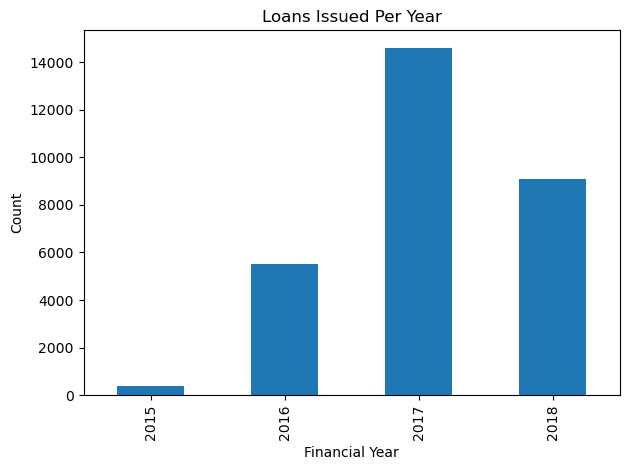

In [15]:
# IF FORMAT IS NOT PASSED -> SLOWS DOWN THE PROCESS
# "Could not infer format, so each element will be parsed individually..." 
Joint_Loan['issue_d'] = pd.to_datetime(Joint_Loan['issue_d'], format='%b-%Y')

Joint_Loan['issue_d'].dt.year.value_counts().sort_index().plot.bar()

plt.title('Loans Issued Per Year')
plt.xlabel('Financial Year')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

In [16]:
#set fraction
frac = 0.80
#get fractions and make deep copy
df_train = Joint_Loan.loc[Joint_Loan['issue_d']  < Joint_Loan['issue_d'].quantile(frac)]
df_test =  Joint_Loan.loc[Joint_Loan['issue_d'] >= Joint_Loan['issue_d'].quantile(frac)]

In [17]:
#save as compressed zipped files to save space
df_test.to_csv('/Users/gopaljee45/Desktop/codinG/SA_2025/Default_Loan_Prediction/Data/df_test_jl.csv.zip')
df_train.to_csv('/Users/gopaljee45/Desktop/codinG/SA_2025/Default_Loan_Prediction/Data/df_train_jl.csv.zip')

In [18]:
leak_cols = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
             'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
             'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 
             'initial_list_status', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct','last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'sec_app_collections_12_mths_ex_med',
             'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
             'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  
             'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq',     'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 
             'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'last_fico_range_high','last_fico_range_low','url','id','title','addr_state',
             'tot_hi_cred_lim','total_bal_ex_mort', 'total_bc_limit', 'sec_app_chargeoff_within_12_mths',
             'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 
             'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
             'total_rev_hi_lim']
#drop leaks
df_small = df_train.drop(columns=leak_cols, axis=1)
drop_col_count = len(leak_cols)
print("The new dataframe has {} columns and lost {} after dropping future leaks".format(df_small.shape[1],
                                                                           drop_col_count))

The new dataframe has 84 columns and lost 67 after dropping future leaks


In [19]:
df_small.shape

(22963, 84)

In [20]:
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = df_small.apply(pd.Series.nunique)
#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

['policy_code', 'application_type', 'hardship_type', 'deferral_term', 'hardship_length']


In [21]:
# drop the redundant columns
df_small = df_small.drop(columns=single_value_cols)

In [22]:
#make dataframe to record mean missing
nan_df = pd.DataFrame(df_small.isna().mean(), columns=['mean_nan'])
#add dtypes
nan_df['dtypes'] = df_small.dtypes
#sort by most missing at top
nan_df = nan_df.sort_values(by=['mean_nan'], ascending=False)

nan_df = nan_df.reset_index()

nan_df.head()

,index,mean_nan,dtypes
0,member_id,1.000000,float64
1,desc,1.000000,object
2,orig_projected_additional_accrued_interest,0.988111,float64
3,hardship_last_payment_amount,0.983582,float64
4,hardship_payoff_balance_amount,0.983582,float64


In [23]:
# a=df_small.isnull().sum()/len(df_small)*100
# variables = df_small.columns
# variable = [ ]
# for i in range(0,len(df_small.columns)):
#     if a[i]<50:   #setting the threshold as 90% (MissingValue)
#         variable.append(variables[i])
#  # Dropping Columns based on missing data being more than 60% 
# drop_columns1=list(set(variables) - set(variable))
# df_drop_nan=df_small.drop(columns=drop_columns1)

a = df_small.isnull().sum() / len(df_small) * 100
variables = df_small.columns

variable = []
for i in range(len(variables)):
    if a.iloc[i] < 50:   # use .iloc for position
        variable.append(variables[i])

drop_columns1 = list(set(variables) - set(variable))
df_drop_nan = df_small.drop(columns=drop_columns1)


In [24]:
df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22963 entries, 2 to 2260663
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   loan_amnt                  22963 non-null  float64       
 1   term                       22963 non-null  object        
 2   int_rate                   22963 non-null  float64       
 3   installment                22963 non-null  float64       
 4   grade                      22963 non-null  object        
 5   sub_grade                  22963 non-null  object        
 6   emp_title                  19652 non-null  object        
 7   emp_length                 22963 non-null  object        
 8   home_ownership             22963 non-null  object        
 9   annual_inc                 22963 non-null  float64       
 10  verification_status        22963 non-null  object        
 11  issue_d                    22963 non-null  datetime64[ns]
 12  loan_st

In [25]:
# my_report.show_html('Joint_Loan.html')

In [92]:
# quick inspection — run in notebook
print(df_drop_nan['earliest_cr_line'].dropna().sample(50, random_state=0).values)


['Jul-2008' 'Sep-1997' 'Dec-1992' 'Sep-2005' 'Jun-2011' 'Jun-2006'
 'Jun-1996' 'Sep-1998' 'Jun-2000' 'Apr-2008' 'Jul-2001' 'Jan-2000'
 'Mar-2013' 'Oct-1993' 'Apr-2004' 'Jul-2002' 'Jul-2001' 'Jan-2002'
 'Apr-2014' 'Nov-2007' 'Nov-2004' 'May-2009' 'Jul-2012' 'Jan-2008'
 'Jun-2000' 'Jun-1990' 'Nov-1998' 'Jan-2006' 'May-1996' 'May-1991'
 'Sep-2010' 'Dec-2001' 'Oct-2004' 'Mar-1994' 'Oct-1993' 'Jan-1967'
 'Oct-2002' 'Jul-2000' 'Jan-2013' 'Nov-2007' 'Feb-2002' 'Aug-2005'
 'Nov-2008' 'Dec-2006' 'Jan-1995' 'Mar-2002' 'Oct-2005' 'Oct-2007'
 'Oct-2002' 'Aug-2006']


In [93]:
def df_object_to_num(df_obj):
    
    """Custom function to transform categorical features into numerical ones
    This function will also be applied on the testing data so that we apply the same exact kind of transformation
    """
    
    #make deep copy
    df_num = df_obj.copy()
    
    col_drop_list = ['emp_title']
    
    df_num['mort_acc'] = np.where(df_num['mort_acc'].isnull(), 0,df_num['mort_acc'])
    #pub_rec_bankruptcies
    df_num['pub_rec_bankruptcies'] = np.where(df_num['pub_rec_bankruptcies']>0, 1, 0)
    # pub_rec
    df_num['pub_rec'] = np.where(df_num['pub_rec']>0, 1, 0)
    
     ### instantiate dicts ### 
    term_to_int = {' 36 months': 1,
                   ' 60 months': 2}
    grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))
    #copied from above, we can write a function to generate this dict
    sub_grade_sorted = {'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
                        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
                        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
                        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
                        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
                        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
                        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34}    
    home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }
    ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0} 
    #replacements
    df_num['verification_status_joint'] = np.where(df_num['verification_status_joint'].isnull(), 'Not Verified',df_num['verification_status_joint'])

    df_num.replace({'term': term_to_int, 
                    'grade':grade_to_int,
                    'sub_grade': sub_grade_sorted,
                    'home_ownership':home_to_int,
                    'verification_status':ver_stat_to_int,
                   'verification_status_joint':ver_stat_to_int}, inplace=True)
    col_drop_list.append('zip_code')
    
    df_num['il_util'] = np.where(df_num['il_util'].isnull(),df_num['il_util'].mean() , df_num['il_util'])
    df_num['revol_util'] = np.where(df_num['revol_util'].isnull(),df_num['revol_util'].mean() , df_num['revol_util'])
    df_num['dti'] = np.where(df_num['dti'].isnull(),df_num['dti'].mean() , df_num['dti'])

    df_num['fico_avg_score'] = (df_num['fico_range_high']+df_num['fico_range_low'] )/2
    col_drop_list.extend(['fico_range_high','fico_range_low'])

    df_num['sec_fico_avg_score'] = (df_num['sec_app_fico_range_high']+df_num['sec_app_fico_range_low'] )/2
    col_drop_list.extend(['sec_app_fico_range_high','sec_app_fico_range_low'])
    
    # df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
    # df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    df_num['earliest_cr_line'] = pd.to_datetime(df_num['earliest_cr_line'], format='%b-%Y', errors='coerce')
    df_num['issue_d'] = pd.to_datetime(df_num['issue_d'], format='%b-%Y', errors='coerce')



    credit_hist= df_num['issue_d'] - df_num['earliest_cr_line']
    df_num['credit_hist']=credit_hist.dt.days
    col_drop_list.append('earliest_cr_line')

    # df_num['sec_app_earliest_cr_line']=  pd.to_datetime(df_num['sec_app_earliest_cr_line'], infer_datetime_format=True)
    # df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    df_num['issue_d'] = pd.to_datetime(df_num['issue_d'], format='%b-%Y', errors='coerce')
    df_num['sec_app_earliest_cr_line'] = pd.to_datetime(df_num['sec_app_earliest_cr_line'], format='%b-%Y', errors='coerce')


    
    credit_hist= df_num['issue_d'] - df_num['sec_app_earliest_cr_line']
    df_num['sec_credit_hist']=credit_hist.dt.days
    col_drop_list.append('sec_app_earliest_cr_line')
    col_drop_list.append('issue_d')
    
   

    #Balance_annual_income
    df_num['balance_annual_inc'] = np.where(df_num['annual_inc']==0,0 , df_num['loan_amnt'] / df_num['annual_inc'])
    
    #Balance_annual_income
    df_num['sec_balance_annual_inc'] = np.where(df_num['annual_inc_joint']==0,0 , df_num['loan_amnt'] / df_num['annual_inc_joint'])
    
    df_num['annual_inc']+=1
    df_num['annual_inc_joint']+=1
    df_num['annual_inc']=np.log(df_num['annual_inc'])
    df_num['total_bal_il']+=1
    df_num['total_bal_il']=np.log(df_num['total_bal_il'])
    df_num['revol_bal']+=1
    df_num['revol_bal']=np.log(df_num['revol_bal'])
    df_num['revol_bal_joint']+=1
    df_num['revol_bal_joint']=np.log(df_num['revol_bal_joint'])
    df_num['annual_inc_joint']=np.log(df_num['annual_inc_joint'])
    df_num['max_bal_bc']+=1
    df_num['max_bal_bc']=np.log(df_num['max_bal_bc'])
    
    df_num['inst_amnt_ratio']=df_num['installment']/df_num['loan_amnt']
    col_drop_list.extend(['installment','loan_amnt'])
    
     # credit_line_ratio 
    df_num['credit_line_ratio']=df_num['open_acc']/df_num['total_acc']
    col_drop_list.extend(['open_acc','total_acc'])
    
    df_num  = df_num.drop(columns=col_drop_list)
    df_num=df_num.dropna()

    return df_num

In [94]:
#make entries numerical
df_num = df_object_to_num(df_drop_nan)
df_num.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,pub_rec_bankruptcies,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,fico_avg_score,sec_fico_avg_score,credit_hist,sec_credit_hist,balance_annual_inc,sec_balance_annual_inc,inst_amnt_ratio,credit_line_ratio
459321,1,10.91,6,26,10,4,11.225257,1,0,2,38.240000,0,9.832689,59.5,11.782960,25.23,1,0.0,5.0,1.0,2.0,12.0,12.161630,67.0,2.0,2.0,8.636930,64.0,0.0,1.0,1.0,1.0,0,10.778143,0.0,1.0,6.0,49.3,3.0,9.0,717.0,612.0,5054,7489.0,0.160000,0.091603,0.032697,0.323529
459376,1,30.75,2,5,10,4,11.350418,1,1,2,16.070000,1,8.909641,31.4,11.487618,14.31,1,4.0,3.0,2.0,2.0,2.0,10.523903,99.0,3.0,3.0,8.421343,73.0,2.0,1.0,7.0,3.0,0,9.944582,1.0,0.0,6.0,31.5,1.0,7.0,697.0,577.0,4689,2254.0,0.401471,0.350000,0.042864,0.769231
459384,1,16.02,5,20,10,4,11.018646,1,0,2,7.630000,1,8.386173,31.3,11.669938,3.98,1,1.0,1.0,1.0,1.0,9.0,8.725670,77.0,2.0,2.0,7.575585,48.0,0.0,2.0,1.0,1.0,1,9.263312,0.0,1.0,3.0,88.5,0.0,3.0,692.0,657.0,8189,5451.0,0.102049,0.053205,0.035168,0.636364
459431,2,19.42,4,17,0.5,4,0.000000,0,0,2,32.176832,0,8.768885,50.2,11.512935,9.00,0,0.0,0.0,1.0,1.0,8.0,9.494165,81.0,1.0,1.0,8.586906,67.0,0.0,0.0,2.0,0.0,0,9.199987,2.0,0.0,8.0,58.2,0.0,7.0,717.0,667.0,3045,5329.0,0.000000,0.144000,0.026172,0.714286
459617,2,20.39,4,16,1,3,11.407576,0,1,1,43.110000,0,10.930854,94.1,12.022018,32.96,0,0.0,5.0,1.0,3.0,8.0,11.444122,44.0,0.0,2.0,9.493412,67.0,2.0,1.0,11.0,2.0,0,11.465173,1.0,2.0,18.0,75.1,4.0,22.0,682.0,672.0,8738,8677.0,0.266667,0.144251,0.026712,0.500000


In [28]:
#drop leak columns
df_test = df_test.drop(columns=leak_cols, axis=1)

# drop the redundant columns
df_test = df_test.drop(columns=single_value_cols)

#drop the columns
df_test = df_test.drop(columns=drop_columns1)

In [95]:
#make numerical
df_test_num = df_object_to_num(df_test)

In [30]:
#save as compressed zipped files to save space
df_num.to_csv('/Users/gopaljee45/Desktop/codinG/SA_2025/Default_Loan_Prediction/Data/df_train_jl_scale.csv')

In [31]:
ss = StandardScaler()
df_train_num=df_num.copy()

target_col = 'loan_status'

#feature space
X_train = df_train_num.drop(columns=[target_col])
X_test = df_test_num.drop(columns=[target_col])

#target variable
y_train = df_train_num[target_col]
y_test = df_test_num[target_col]


X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [32]:
#ROC dict for TPR and FPR values
roc_dict = {}

#precision recall curve
prc_dict = {}


def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [33]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [34]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

/Users/gopaljee45/miniconda3/envs/sa2025/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.679490,0.587566,0.662658,0.633528,0.645532,lr
recall,0.880244,0.291233,0.662658,0.585738,0.662658,lr
f1-score,0.766947,0.389437,0.662658,0.578192,0.627492,lr
support,3933.000000,2304.000000,0.662658,6237.000000,6237.000000,lr


In [35]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [36]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.695180,0.647660,0.686227,0.671420,0.677625,gbtree
recall,0.894737,0.330295,0.686227,0.612516,0.686227,gbtree
f1-score,0.782435,0.437482,0.686227,0.609958,0.655006,gbtree
support,3933.000000,2304.000000,0.686227,6237.000000,6237.000000,gbtree


In [37]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [38]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [39]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.684466,0.624655,0.674042,0.654561,0.662371,rf
recall,0.896262,0.294705,0.674042,0.595484,0.674042,rf
f1-score,0.776175,0.400472,0.674042,0.588324,0.637387,rf
support,3933.000000,2304.000000,0.674042,6237.000000,6237.000000,rf


In [40]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [45]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [50]:
import numpy as np, xgboost as xgb
print(np.__version__, xgb.__version__)


2.2.5 1.7.6


In [54]:
# xgb_clf = xgb.XGBClassifier(n_estimators=300,
#                             subsample=0.9,
#                             n_jobs=-1,
#                             enable_categorical=True)   # <<-- important

# xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
# xgb_report.head()

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns

# Convert them to category codes
for c in cat_cols:
    X_train[c] = X_train[c].astype('category').cat.codes.replace(-1, np.nan)
    X_test[c]  = X_test[c].astype('category').cat.codes.replace(-1, np.nan)

# Now train without enable_categorical
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    subsample=0.9,
    n_jobs=-1,
)
xgb_clf.fit(X_train, y_train)

xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.701732,0.572665,0.66827,0.637199,0.654053,xgb
recall,0.824307,0.401910,0.66827,0.613108,0.668270,xgb
f1-score,0.758097,0.472328,0.66827,0.615213,0.652531,xgb
support,3933.000000,2304.000000,0.66827,6237.000000,6237.000000,xgb


In [55]:
#metrics for svc
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [56]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [57]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

/Users/gopaljee45/miniconda3/envs/sa2025/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.649473,0.377086,0.455828,0.513280,0.548851,svc
recall,0.297737,0.725694,0.455828,0.511716,0.455828,svc
f1-score,0.408298,0.496290,0.455828,0.452294,0.440803,svc
support,3933.000000,2304.000000,0.455828,6237.000000,6237.000000,svc


In [58]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [59]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [60]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.650719,0.428934,0.594677,0.539826,0.568790,KNN
recall,0.771167,0.293403,0.594677,0.532285,0.594677,KNN
f1-score,0.705841,0.348454,0.594677,0.527147,0.573819,KNN
support,3933.000000,2304.000000,0.594677,6237.000000,6237.000000,KNN


In [61]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [62]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [63]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost', 'SVC', 'KNN'])

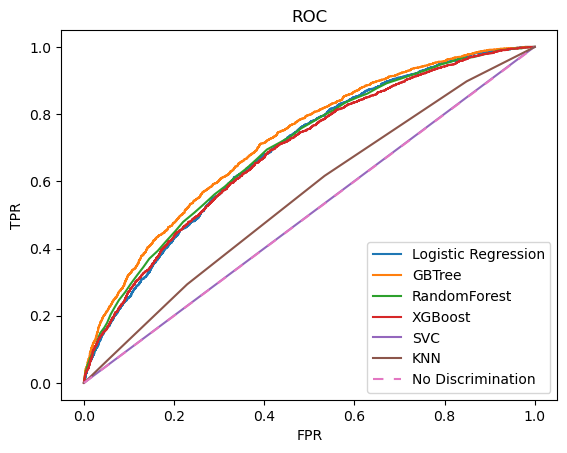

In [64]:
# for key in roc_dict:
#     clf = roc_dict[key]
#     plt.plot(clf['fpr'], clf['tpr'], label=key)
# plt.xlabel("FPR")
# plt.ylabel("TPR")
# plt.title("ROC")
# plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
# plt.savefig(os.path.join('plots/roc_curve_all_models.png'))
# plt.legend()
# plt.show()


import os

# Create 'plots' directory if it doesn't exist
os.makedirs("plots", exist_ok=True)

for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))

# Now safe to save
plt.savefig(os.path.join("plots", "roc_curve_all_models.png"))

plt.legend()
plt.show()


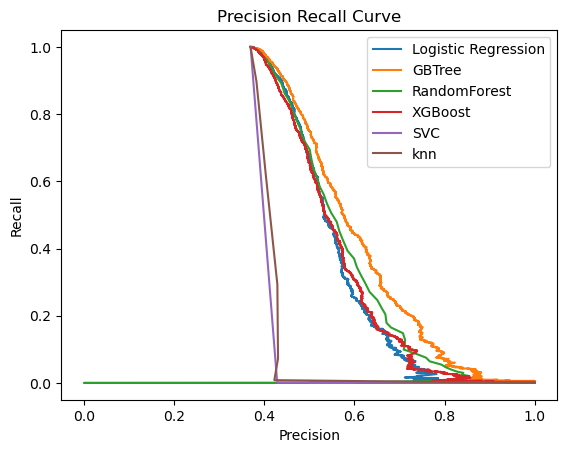

In [65]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('plots/prc_curve_all_models.png'))

plt.legend()

plt.show()

In [66]:
gbtree.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3242,  691],
       [1378,  926]])

In [67]:
fpr, tpr, thresholds = roc_curve(y_test,gbtree.predict_proba(X_test)[:,1],pos_label=1)

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       gbtree.predict_proba(X_test)[:,1],
                                                       pos_label=1)

In [69]:
gb_auc = roc_auc_score(y_test, gbtree.predict_proba(X_test)[:,1])
print("gb_auc: {}".format(gb_auc))

gb_auc: 0.7194902640054242


In [70]:
X_test.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,pub_rec,revol_bal,revol_util,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,pub_rec_bankruptcies,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,fico_avg_score,sec_fico_avg_score,credit_hist,sec_credit_hist,balance_annual_inc,sec_balance_annual_inc,inst_amnt_ratio,credit_line_ratio
421212,1,14.07,2,22,7,0,10.463132,0,0,53.03,1,9.609452,60.3,11.482477,21.04,0,3.0,3.0,2.0,3.0,3.0,10.905662,88.0,1.0,1.0,5.293305,80.0,2.0,3.0,3.0,2.0,1,10.067815,3.0,3.0,9.0,63.1,3.0,6.0,682.0,677.0,4230,6909,0.714286,0.257732,0.023305,0.444444
421222,0,17.47,3,5,5,1,10.839601,0,1,10.56,1,1.098612,0.1,11.711785,7.47,0,1.0,3.0,0.0,1.0,17.0,10.030384,95.0,2.0,2.0,1.098612,86.0,4.0,0.0,2.0,0.0,0,7.156956,5.0,1.0,13.0,32.0,9.0,12.0,707.0,637.0,3652,4046,0.019608,0.008197,0.035890,0.555556
421291,1,30.65,1,29,4,0,10.714440,0,1,43.63,1,9.522227,56.9,11.884496,32.01,0,0.0,9.0,1.0,3.0,8.0,11.212509,102.0,0.0,1.0,7.788626,85.0,1.0,1.0,1.0,1.0,1,11.406030,0.0,3.0,17.0,68.5,5.0,13.0,687.0,672.0,3407,3468,0.444444,0.137931,0.032754,0.857143
421307,0,20.39,3,4,5,1,10.341775,1,3,20.79,0,0.000000,0.0,11.643962,21.61,1,0.0,7.0,1.0,3.0,8.0,10.587291,97.0,0.0,1.0,0.000000,93.0,1.0,0.0,3.0,0.0,0,8.526945,3.0,0.0,9.0,82.8,4.0,5.0,707.0,632.0,2130,4230,0.193548,0.052632,0.037363,1.000000
421324,0,19.42,3,3,9,0,10.714440,2,0,62.70,0,10.674105,45.0,12.460719,30.04,2,0.0,6.0,0.0,0.0,57.0,11.943941,65.0,0.0,0.0,9.483340,48.0,0.0,0.0,0.0,0.0,0,11.774012,3.0,4.0,20.0,65.1,7.0,18.0,697.0,687.0,5569,7183,0.805556,0.140504,0.036869,0.562500


In [71]:
# #define location to save trained model
# save_model_dir = os.path.join('Models/gb_default_params_joint.pickle')
# print("Saving model at: {}".format(save_model_dir))

# #save the model
# with open(save_model_dir, 'wb') as handle:
#     pickle.dump(xgb_clf,
#                 handle,
#                 protocol=pickle.HIGHEST_PROTOCOL)


import os, pickle

# Ensure directory exists before saving
os.makedirs("Models", exist_ok=True)

# Define location to save trained model
save_model_dir = os.path.join('Models', 'gb_default_params_joint.pickle')
print("Saving model at: {}".format(save_model_dir))

# Save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)


Saving model at: Models/gb_default_params_joint.pickle


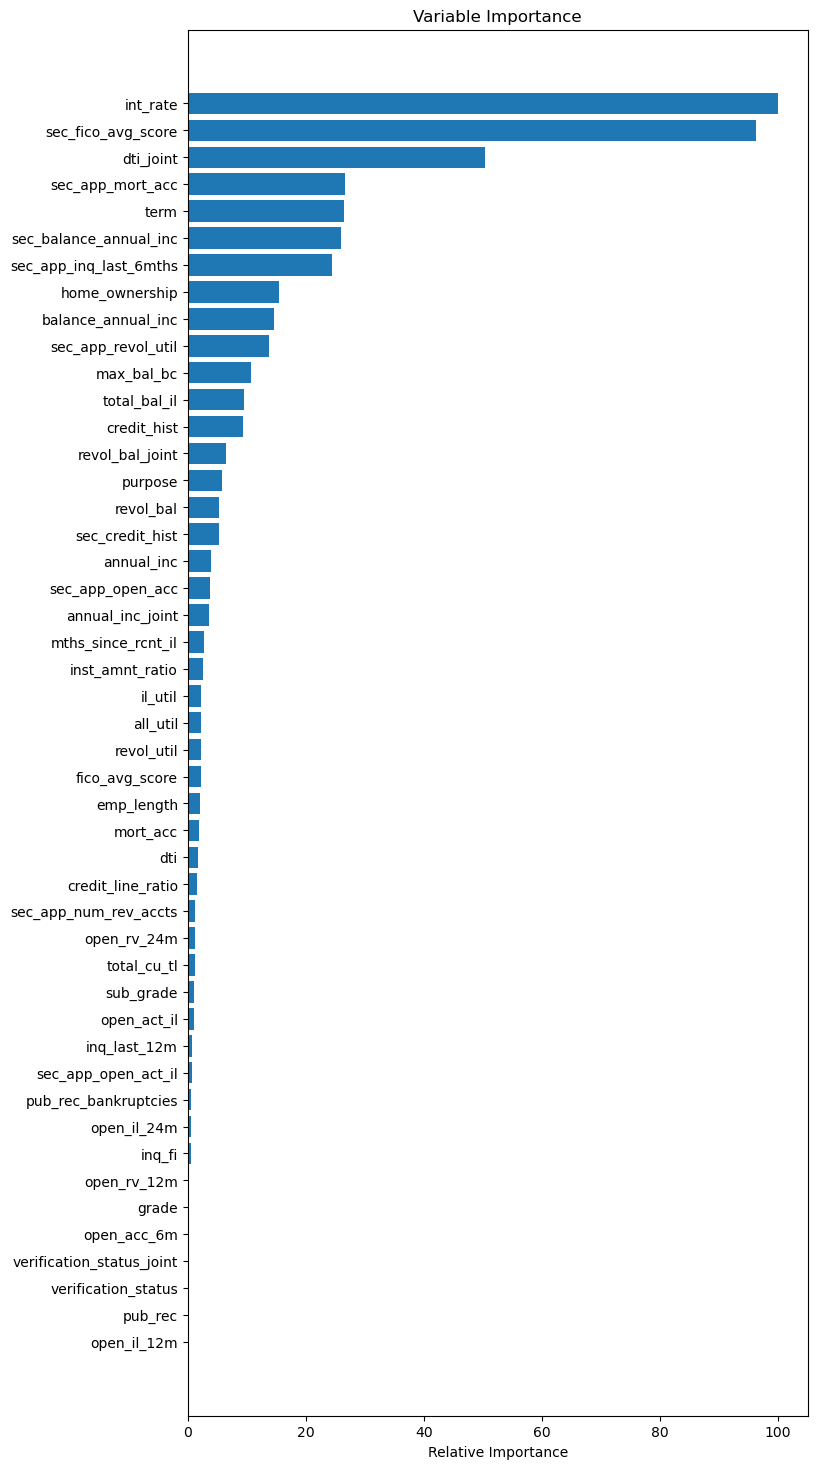

In [72]:
feature_importance = gbtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


In [73]:
X_train.keys()[sorted_idx]

Index(['open_il_12m', 'pub_rec', 'verification_status',
       'verification_status_joint', 'open_acc_6m', 'grade', 'open_rv_12m',
       'inq_fi', 'open_il_24m', 'pub_rec_bankruptcies', 'sec_app_open_act_il',
       'inq_last_12m', 'open_act_il', 'sub_grade', 'total_cu_tl',
       'open_rv_24m', 'sec_app_num_rev_accts', 'credit_line_ratio', 'dti',
       'mort_acc', 'emp_length', 'fico_avg_score', 'revol_util', 'all_util',
       'il_util', 'inst_amnt_ratio', 'mths_since_rcnt_il', 'annual_inc_joint',
       'sec_app_open_acc', 'annual_inc', 'sec_credit_hist', 'revol_bal',
       'purpose', 'revol_bal_joint', 'credit_hist', 'total_bal_il',
       'max_bal_bc', 'sec_app_revol_util', 'balance_annual_inc',
       'home_ownership', 'sec_app_inq_last_6mths', 'sec_balance_annual_inc',
       'term', 'sec_app_mort_acc', 'dti_joint', 'sec_fico_avg_score',
       'int_rate'],
      dtype='object')

In [74]:
keep_columns=['credit_hist', 'total_bal_il',
       'home_ownership', 'balance_annual_inc', 'sec_app_revol_util',
       'sec_balance_annual_inc', 'term', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'dti_joint', 'sec_fico_avg_score', 'sub_grade']
select_X_train=X_train[keep_columns]
select_X_test=X_test[keep_columns]

In [75]:
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    "gbtree__max_depth":[3,5,8],
    'gbtree__learning_rate': [0.01,0.05,0.1],
    'gbtree__n_estimators' : [100,500,1000],
    }

#define the pipeline
model_pipe = Pipeline([('gbtree', GradientBoostingClassifier())])

#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=4, 
                   verbose=50, 
                   scoring='roc_auc')


#fit to training data
clf.fit(select_X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4; 2/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=500
[CV 3/4; 1/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=100
[CV 4/4; 2/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=500
[CV 4/4; 1/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=100
[CV 2/4; 2/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=500
[CV 2/4; 1/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=100
[CV 1/4; 1/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=100
[CV 3/4; 2/27] START gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=500
[CV 4/4; 1/27] END gbtree__learning_rate=0.01, gbtree__max_depth=3, gbtree__n_estimators=100;, score=0.702 total time=   2.6s
[CV 2/4; 1/27] END gbtree__learning_rate=0.01, gbtre

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'gbtree__learning_rate': [0.01, 0.05, ...], 'gbtree__max_depth': [3, 5, ...], 'gbtree__n_estimators': [100, 500, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,4
,verbose,50
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [76]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'gbtree__learning_rate': 0.01, 'gbtree__max_depth': 3, 'gbtree__n_estimators': 1000}
Best model score: 

0.7223377646022111


In [77]:
y_pred = clf.predict(select_X_test)
confusion_matrix(y_test, y_pred)

array([[3508,  425],
       [1579,  725]])

In [78]:
f1_gb = f1_score(y_test, y_pred)

print("f1_gb (binary): {}\n".format(f1_gb))
print(classification_report(y_test,y_pred))

f1_gb (binary): 0.4198031268094962

              precision    recall  f1-score   support

           0       0.69      0.89      0.78      3933
           1       0.63      0.31      0.42      2304

    accuracy                           0.68      6237
   macro avg       0.66      0.60      0.60      6237
weighted avg       0.67      0.68      0.65      6237



In [79]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(select_X_test)[:,1],
                                 pos_label=1)

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(select_X_test)[:,1],
                                                       pos_label=1)

In [81]:
gb_auc = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
print("gb_auc: {}".format(gb_auc)) 

gb_auc: 0.7066980870554003


In [82]:
#define location to save trained model
save_model_dir = os.path.join('models','gb_cv_compact_joint.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: models/gb_cv_compact_joint.pkl


In [83]:
select_X_train=X_train[keep_columns].values
select_X_test=X_test[keep_columns].values

In [84]:
y_train=y_train.values

In [85]:
from tqdm import tqdm

auc_arr = []
for _ in tqdm(range(100)):
    idx = np.random.choice(np.arange(len(select_X_train)), 8000, replace=True)
    X_temp = select_X_train[idx]
    y_temp = y_train[idx]
        
    #instantiate classifier
    clf=GradientBoostingClassifier(learning_rate=0.01, n_estimators = 1000,max_depth=3)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    score = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
    auc_arr.append(score)

100%|██████████| 100/100 [21:25<00:00, 12.85s/it]


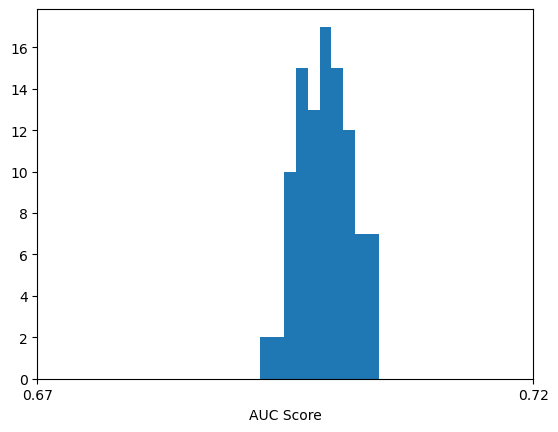

In [86]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.67, 0.77, 0.05))
plt.savefig(os.path.join("plots", 'auc_632_sampling_joint.png'))
plt.show()